In [1]:
from pathlib import Path
from dataclasses import dataclass
import pandas as pd
from functools import cached_property
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use("../../config/DIT_HAP.mplstyle")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]
AX_WIDTH, AX_HEIGHT = plt.rcParams["figure.figsize"]

# 1. Configuration

In [2]:
@dataclass
class Config:
    project_dir: Path = Path("../../results/HD_DIT_HAP_generationRAW")
    distance_threshold: int = 150
    width: int = 10

    @cached_property
    def annotations(self):
        return pd.read_csv(self.project_dir / "12_concatenated/annotations.tsv", sep="\t", index_col=[0,1,2,3])
    
    @cached_property
    def insertion_level_results(self):
        return pd.read_csv(self.project_dir / "15_insertion_level_curve_fitting/insertion_level_fitting_statistics.tsv", sep="\t", index_col=[0,1,2,3])
    
    @cached_property
    def gene_level_results(self):
        return pd.read_csv(self.project_dir / "17_gene_level_curve_fitting/gene_level_fitting_statistics.tsv", sep="\t", index_col=0)
    
    def __post_init__(self):
        self.output_dir = self.project_dir / "22_upstream_and_downstream_analysis"
        self.output_dir.mkdir(parents=True, exist_ok=True)

        self.in_gene_insertions = self.annotations.query("Type != 'Intergenic region' and Distance_to_stop_codon > 4").copy()
    

# 1.Load data

In [3]:
data_config = Config()

genes_with_wrong_DIT_HAP = [
    "hul6",
    "sca1",
    "pmc3",
    "ymr1",
    "mkh1",
    "msn5",
    "tsc2",
    "phi1",
    "mal1",
    "num1",
    "vps1301",
    "SPCC24B10.18",
]

non_essential_N_terminus = pd.read_excel("../../resources/non_esential_domain_candidates.xlsx", sheet_name="Non-essential N terminus")
non_essential_C_terminus = pd.read_excel("../../resources/non_esential_domain_candidates.xlsx", sheet_name="Non-essential C terminus")
non_essential_N_and_C_termini = pd.read_excel("../../resources/non_esential_domain_candidates.xlsx", sheet_name="Non-essential N and C termini")

non_essential_domain_candidate_genes = non_essential_N_terminus["Gene"].tolist() + non_essential_C_terminus["Gene"].tolist() + non_essential_N_and_C_termini["Gene"].tolist()

# 2.Define the UTRs

In [4]:
def assign_insertion_direction(insertion_strand: str, region_strand: str) -> str:
    """Assign the insertion direction to the insertion based on the insertion and region strands."""
    if insertion_strand == region_strand:
        return "Forward"
    else:
        return "Reverse"


def assign_UTR_type(row: pd.Series) -> tuple[str, str, str, int]:
    """Assign the UTR type to the insertion based on the distance to the gene boundary."""
    left_gene, right_gene = row["Name"].split("|")
    left_strand, right_strand = row["Strand_Interval"].split("|")
    insertion_strand = row.name[2]
    Distance_to_region_start = row["Distance_to_region_start"]
    Distance_to_region_end = row["Distance_to_region_end"]
    Parental_gene = ""
    Insertion_direction = ""
    UTR_type = ""
    Distance_to_gene_boundary = 0
    if (Distance_to_region_start < 300) and (Distance_to_region_end > 300):
        Parental_gene = left_gene
        Insertion_direction = assign_insertion_direction(insertion_strand, left_strand)
        if left_strand == "+":
            UTR_type = "3UTR"
            Distance_to_gene_boundary = Distance_to_region_start
        else:
            UTR_type = "5UTR"
            Distance_to_gene_boundary = -Distance_to_region_start
    elif (Distance_to_region_start > 300) and (Distance_to_region_end < 300):
        Parental_gene = right_gene
        Insertion_direction = assign_insertion_direction(insertion_strand, right_strand)
        if right_strand == "+":
            UTR_type = "5UTR"
            Distance_to_gene_boundary = -Distance_to_region_end
        else:
            UTR_type = "3UTR"
            Distance_to_gene_boundary = Distance_to_region_end
    return Parental_gene, Insertion_direction, UTR_type, Distance_to_gene_boundary


In [5]:
UTR_insertions = data_config.annotations.query(f"Type == 'Intergenic region' and ((Distance_to_region_start < {data_config.distance_threshold}) or (Distance_to_region_end < {data_config.distance_threshold}))").copy()
UTR_insertions[["Parental_gene", "Insertion_direction", "UTR_type", "Distance_to_gene_boundary"]] = UTR_insertions.apply(assign_UTR_type, axis=1, result_type="expand")
UTR_insertion_LFCs = pd.merge(data_config.insertion_level_results, UTR_insertions, left_index=True, right_index=True, how="inner")
UTR_insertion_LFCs = pd.merge(UTR_insertion_LFCs.reset_index(), data_config.gene_level_results, left_on="Parental_gene", right_on="Name", how="inner", suffixes=("_insertion", "_gene"))
UTR_insertion_LFCs["A_ratio"] = UTR_insertion_LFCs["A_insertion"] / UTR_insertion_LFCs["A_gene"]
UTR_insertion_LFCs["um_ratio"] = UTR_insertion_LFCs["um_insertion"] / UTR_insertion_LFCs["um_gene"]

# 3. in-gene insertions

In [6]:
in_gene_insertion_LFCs = pd.merge(data_config.insertion_level_results, data_config.in_gene_insertions, left_index=True, right_index=True, how="inner")
in_gene_insertion_LFCs = pd.merge(in_gene_insertion_LFCs.reset_index(), data_config.gene_level_results, on="Name", how="inner", suffixes=("_insertion", "_gene"))
in_gene_insertion_LFCs["A_ratio"] = in_gene_insertion_LFCs["A_insertion"] / in_gene_insertion_LFCs["A_gene"]
in_gene_insertion_LFCs["um_ratio"] = in_gene_insertion_LFCs["um_insertion"] / in_gene_insertion_LFCs["um_gene"]

# 4. Select the genes with growth contribution

In [7]:
UTR_insertion_in_nonWT_genes = UTR_insertion_LFCs.query("(um_gene > 0.5)").copy()
UTR_genes = UTR_insertion_in_nonWT_genes["Parental_gene"].unique().tolist()
in_gene_insertion_in_nonWT_genes = in_gene_insertion_LFCs.query("(um_gene > 0.5) and Name in @UTR_genes").copy()

# 5.Plot

In [8]:
def plot_UTR_gene_boundary_insertions(UTR_insertions, gene_insertions, feature="um_ratio"):

    fig, axes = plt.subplots(1,4, figsize=(20,5))

    UTR_5 = UTR_insertions.query("UTR_type == '5UTR'").copy()
    N_terminal_insertions = gene_insertions.query(f"Distance_to_start_codon < {data_config.distance_threshold}").copy()
    N_terminal_insertions["Distance_to_gene_boundary"] = N_terminal_insertions["Distance_to_start_codon"]
    C_terminal_insertions = gene_insertions.query(f"Distance_to_stop_codon < {data_config.distance_threshold}").copy()
    C_terminal_insertions["Distance_to_gene_boundary"] = -C_terminal_insertions["Distance_to_stop_codon"]
    UTR_3 = UTR_insertions.query("UTR_type == '3UTR'").copy()

    width = data_config.width

    titles = ["Upstream", "N-terminus", "C-terminus", "Downstream"]
    for col, col_data in enumerate([UTR_5, N_terminal_insertions, C_terminal_insertions, UTR_3]):
        ax = axes[col]
        # boxplot with bins
        x_bins = range(-data_config.distance_threshold, data_config.distance_threshold + 1, width)

        match col:
            case 0:
                ax.set_xlabel("Distance to start codon (bp)")
            case 1:
                ax.set_xlabel("Distance to start codon (bp)")
            case 2:
                ax.set_xlabel("Distance to stop codon (bp)")
            case 3:
                ax.set_xlabel("Distance to stop codon (bp)")

        
        col_data["bin"] = pd.cut(col_data["Distance_to_gene_boundary"], bins=x_bins)
        col_data["bin_mid"] = col_data["bin"].map(lambda x: x.mid)
        grouped_data = col_data.groupby("bin_mid", observed=True)[feature].apply(list).sort_index()
        grouped_data = grouped_data[grouped_data.map(len) > 1]
        positions = grouped_data.index.tolist()
        boxplot_values = grouped_data.values.tolist()
        bp = ax.boxplot(boxplot_values, positions=positions, widths=width*0.8, patch_artist=True, boxprops=dict(facecolor="grey", alpha=0.5), showfliers=False)

        ax.set_xticks([])
        x_data = col_data["Distance_to_gene_boundary"]
        y_data = col_data[feature]
        # ax.scatter(x_data, y_data, alpha=0.4, s=5, facecolor="none", edgecolor="grey")
        ax.set_title(titles[col])
        ax.set_ylim(-0.2, 1.7)
       
        ax.axhline(0, color="green", linestyle="-", linewidth=2, alpha=0.2)
        ax.axhline(1, color="red", linestyle="-", linewidth=2, alpha=0.2)
        if col > 0:
            ax.spines[["left", "top", "right"]].set_visible(False)
            ax.set_yticks([])
        else:
            ax.spines[["top", "right"]].set_visible(False)
            ax.set_ylabel("DR ratio (insertion/gene)")
            ax.tick_params(axis="y", which="both")

    # plt.show()
    return fig

In [9]:
pdf = PdfPages(data_config.output_dir / "gene_boundary_insertions_analysis.pdf")

## 5.1 Plot UTR and gene boundary insertions

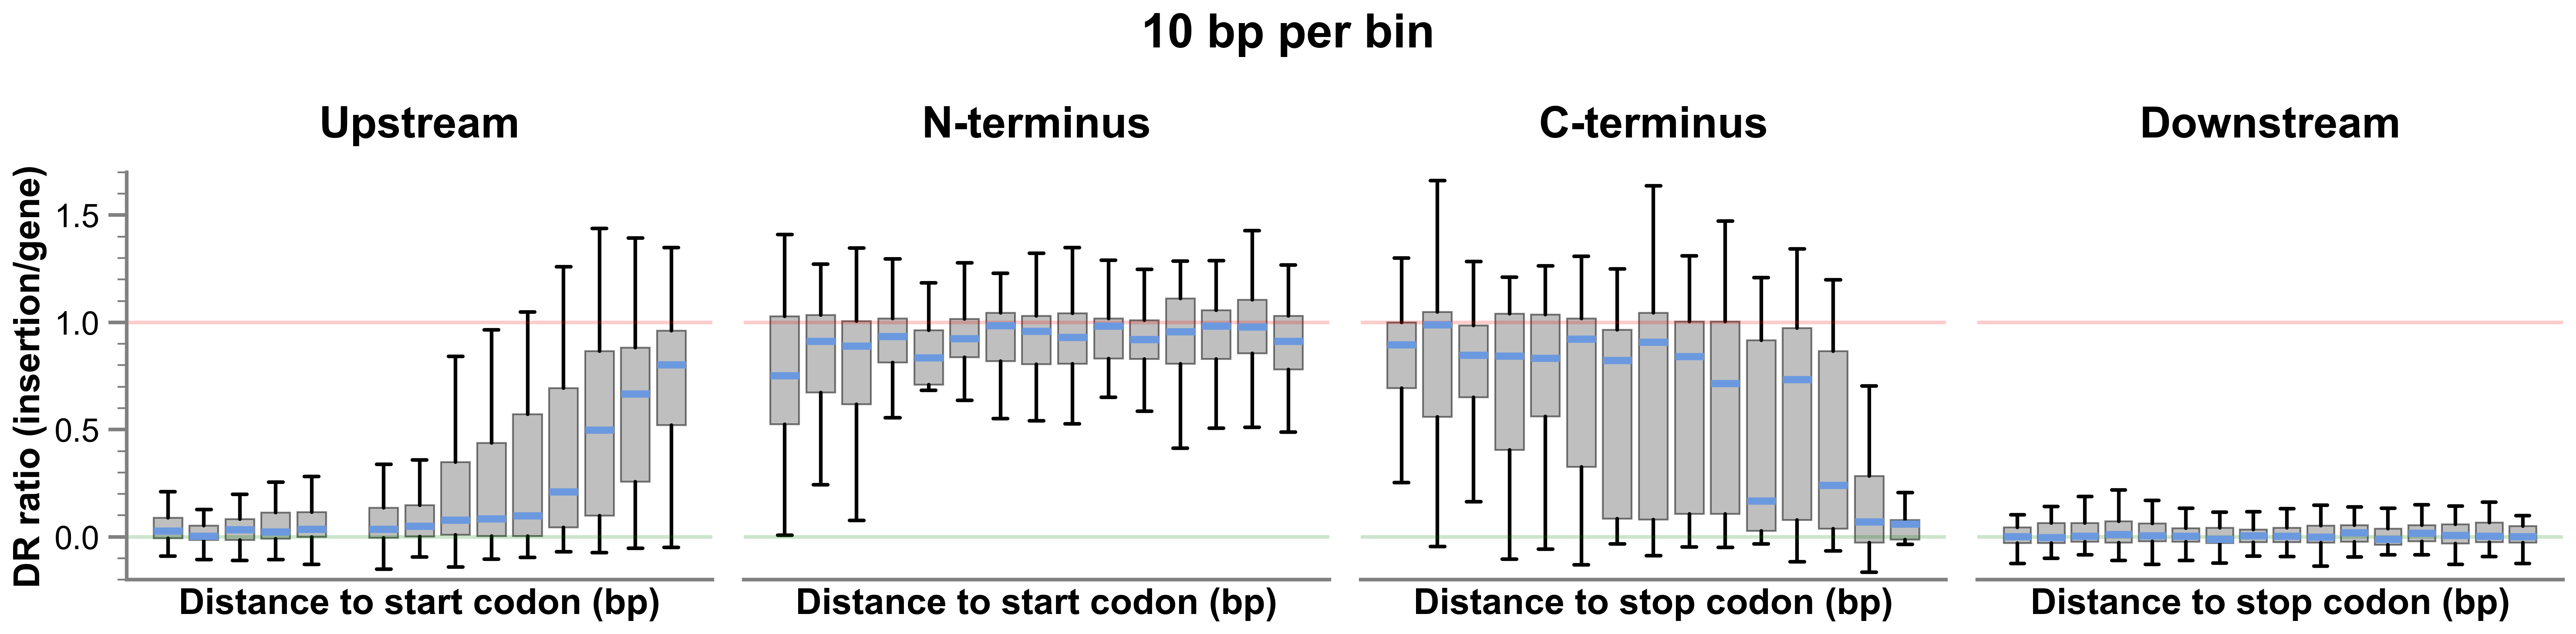

In [10]:
fig = plot_UTR_gene_boundary_insertions(UTR_insertion_in_nonWT_genes, in_gene_insertion_in_nonWT_genes)
fig.suptitle(f"{data_config.width} bp per bin")
pdf.savefig(fig)
plt.show()
plt.close()

## 5.2 Plot Forward insertions

In [12]:
Pair_UTR_insertion_in_nonWT_genes = UTR_insertion_in_nonWT_genes.groupby(["Chr", "Coordinate", "Target"]).filter(lambda x: x["Strand"].unique().tolist() == ["+", "-"]).copy()
Pair_in_gene_insertion_in_nonWT_genes = in_gene_insertion_in_nonWT_genes.groupby(["Chr", "Coordinate", "Target"]).filter(lambda x: x["Strand"].unique().tolist() == ["+", "-"]).copy()

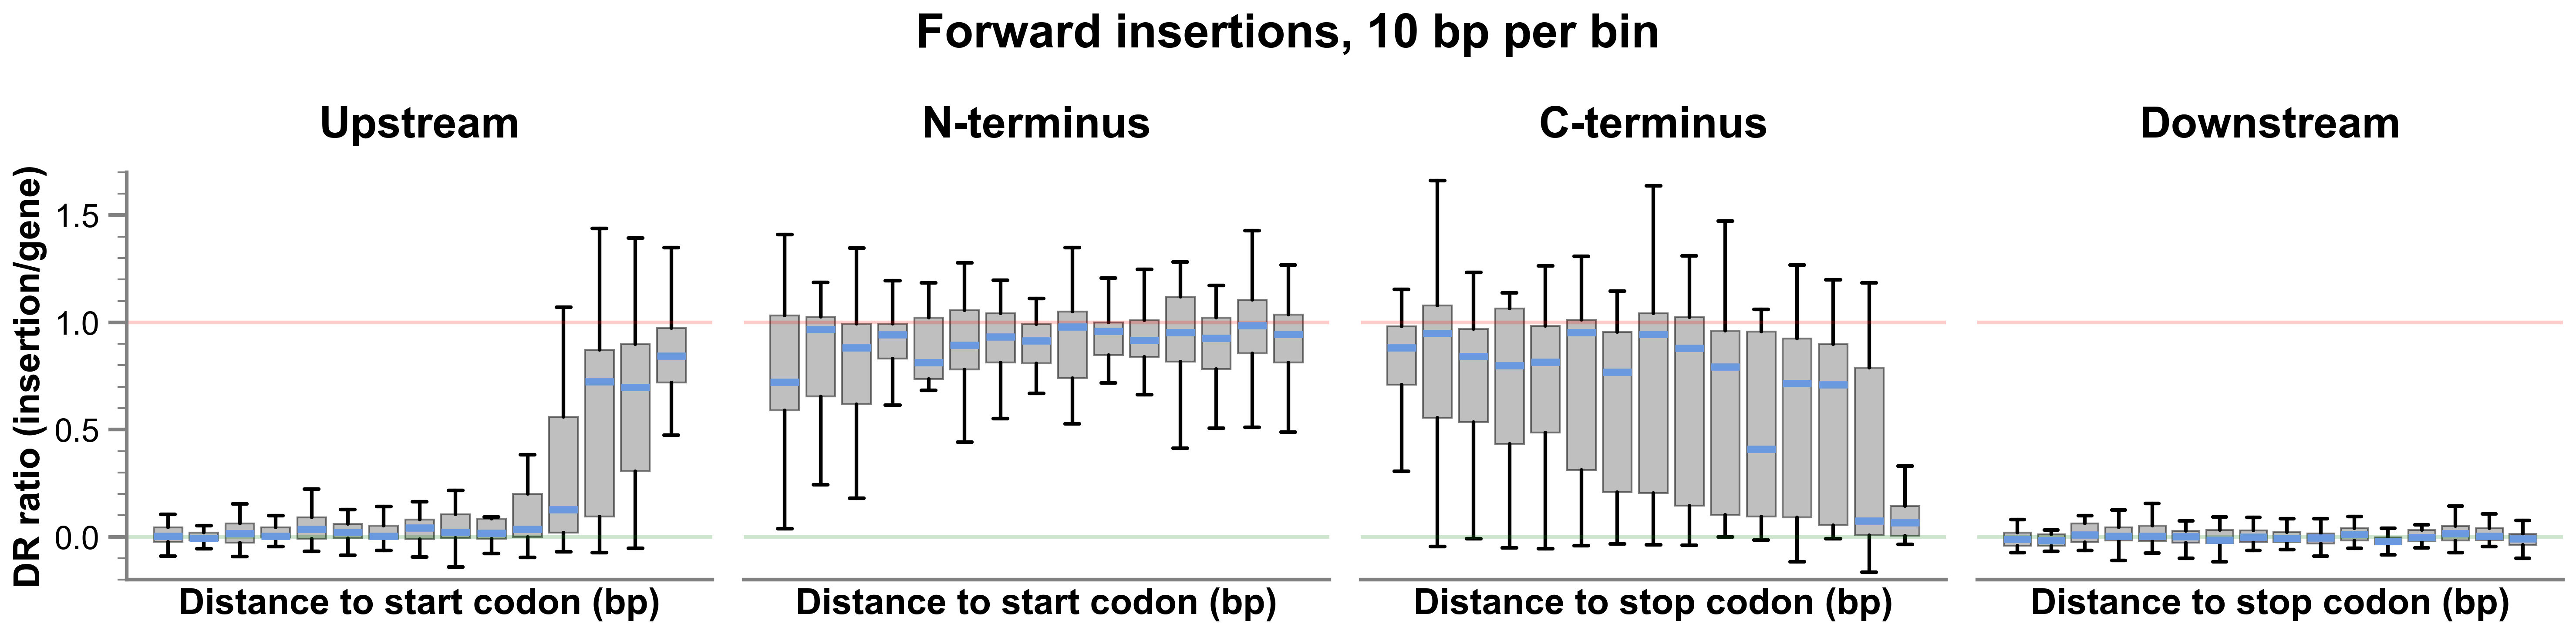

In [13]:
Forward_UTR_insertion_in_nonWT_genes = Pair_UTR_insertion_in_nonWT_genes.query("Insertion_direction == 'Forward'").copy()
Forward_in_gene_insertion_in_nonWT_genes = Pair_in_gene_insertion_in_nonWT_genes.query("Insertion_direction == 'Forward'").copy()
fig = plot_UTR_gene_boundary_insertions(Forward_UTR_insertion_in_nonWT_genes, Forward_in_gene_insertion_in_nonWT_genes)
fig.suptitle(f"Forward insertions, {data_config.width} bp per bin")
pdf.savefig(fig)
plt.show()
plt.close()

## 5.3 Plot Reverse insertions

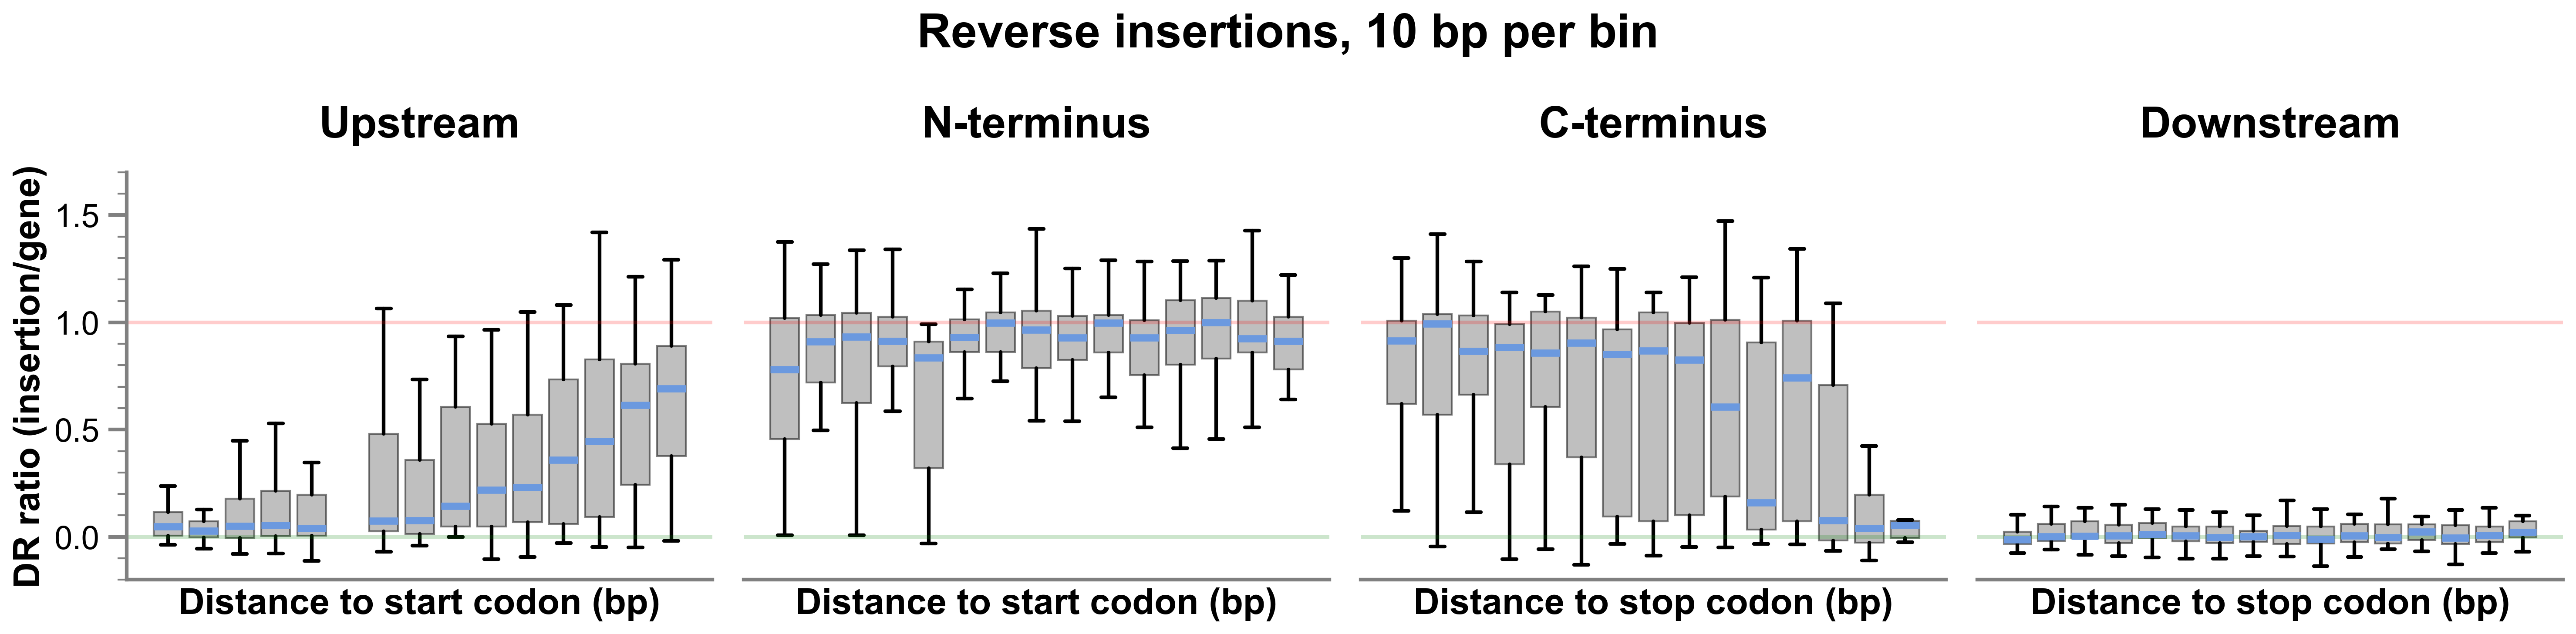

In [14]:
Reverse_UTR_insertion_in_nonWT_genes = Pair_UTR_insertion_in_nonWT_genes.query("Insertion_direction == 'Reverse'").copy()
Reverse_in_gene_insertion_in_nonWT_genes = Pair_in_gene_insertion_in_nonWT_genes.query("Insertion_direction == 'Reverse'").copy()
fig = plot_UTR_gene_boundary_insertions(Reverse_UTR_insertion_in_nonWT_genes, Reverse_in_gene_insertion_in_nonWT_genes)
fig.suptitle(f"Reverse insertions, {data_config.width} bp per bin")
pdf.savefig(fig)
plt.show()
plt.close()

In [15]:
pdf.close()